In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=5).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1])
    plt.show()

In [2]:

import pickle
with open('../../../models/wld/PCA/emb_100/pca.pkl','rb') as f:
    pca_model = pickle.load(f)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("************ NOTE: The torch device is:", device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(16,32,3,2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(32,64,3,2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(64,128,3,2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Conv2d(128,256,3,2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(3*5*256,100),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        
        self.fc = nn.Sequential( 
            nn.Linear(100,3*5*256),
            #nn.BatchNorm2d(6*10*128),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        
        self.decoder = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )


    def forward(self, anchor, positive, negative):
        embedded_anchor   = self.encoder(anchor)
        embedded_positive = self.encoder(positive)
        embedded_negative = self.encoder(negative)
        
        input_to_decoder_anchor   = self.fc(embedded_anchor).view(-1,256,3,5)
        input_to_decoder_positive = self.fc(embedded_anchor).view(-1,256,3,5)
        input_to_decoder_negative = self.fc(embedded_anchor).view(-1,256,3,5)
        
        decoded_anchor   = self.decoder(input_to_decoder_anchor)
        decoded_positive = self.decoder(input_to_decoder_positive)
        decoded_negative = self.decoder(input_to_decoder_negative)
        
        return decoded_anchor, decoded_positive, decoded_negative, embedded_anchor, embedded_positive, embedded_negative
        
    def get_embeding(self,x):
        return self.encoder(x)

model = Net()        
model=model.to(device)
epoch=90
model.load_state_dict(torch.load( '../../../models/wld/AE/alpha_1/emb_100/model/{}.pth'.format(epoch),
                      map_location=device))
model.eval()

************ NOTE: The torch device is: cpu


Net(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten()
    (16): Linear(in_features=3840, out_fe

In [4]:
from tqdm import tqdm 
import numpy as np
from bob.bio.vein.configurations.utfvp import database
import bob.io.base

from bob.bio.vein.preprocessor import NoCrop, TomesLeeMask, HuangNormalization, \
    NoFilter, Preprocessor

preprocessor = Preprocessor(
    crop=NoCrop(),
    mask=TomesLeeMask(),
    normalize=HuangNormalization(),
    filter=NoFilter(),
    )


from bob.bio.vein.extractor import WideLineDetector
WLD_extractor = WideLineDetector()


all_Files = database.objects(protocol='nom', groups='eval')


all_ids = []
for i,obj in tqdm(enumerate(all_Files)):
    all_ids.append(obj.client_id)
selected_ids = list(set(all_ids))[:5]
######################################################################    
import time 
from tqdm import tqdm
all_features = []
all_features_PCA = []
all_features_AE = []
all_features_AE_sigmoid = []
all_ids = []
for i,obj in enumerate(all_Files):
    
    if obj.client_id in selected_ids:
        path=obj.make_path('path_to_utfvp_database','.png')
        image = bob.io.base.load(path)
        #################################
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        datagen = ImageDataGenerator(rotation_range=7,
                                     width_shift_range=0.025,
                                     height_shift_range=0.025,
                                     channel_shift_range=0.075,
                                     zoom_range=(0.95,1.05)
                                     )
        image_reshape = np.reshape(image, [1, 380, 672, 1])
        itr=0
        for image in datagen.flow(image_reshape, seed=itr):
            itr +=1
            if itr>20:
                break
            image_and_mask = preprocessor(image[0,:,:,0])
            WLD_feature = WLD_extractor(image_and_mask)

            WLD_feature_PCA=np.reshape(WLD_feature,(1,-1))
            WLD_feature_PCA = pca_model.transform(WLD_feature_PCA)


            WLD_feature_AE=np.zeros([1,1,WLD_feature.shape[0]+2,WLD_feature.shape[1]-4])
            WLD_feature_AE[0,0,1:-1,:]=WLD_feature[:,2:-2]#/255.
            WLD_feature_AE_ = torch.tensor(WLD_feature_AE, requires_grad=False).float().to(device)
            WLD_feature_AE = model.get_embeding(WLD_feature_AE_).cpu().detach().numpy()
            WLD_feature_AE_sigmoid = model_sigmoid.get_embeding(WLD_feature_AE_).cpu().detach().numpy()

            all_features.append(WLD_feature)
            all_features_AE.append(WLD_feature_AE)
            all_features_AE_sigmoid.append(WLD_feature_AE_sigmoid)
            all_features_PCA.append(WLD_feature_PCA)

            all_ids.append(obj.client_id)

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "
768it [00:00, 517465.94it/s]
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/norm

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/

/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters
/idiap/temp/hotroshi/anaconda3/envs/bob_env_pytorch/lib/python3.7/site-packages/bob/bio/vein/preprocessor/normalize.py:137: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = numpy.linalg.lstsq(A,bl)[0] # obtaining the parameters


### AE-sigmoid

[-103.87117   362.45117    38.738045]


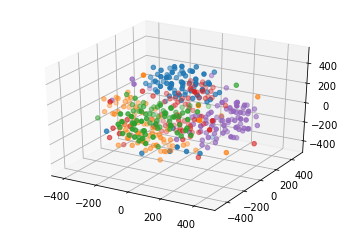

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1], scatter[:,2])
    plt.show()
    
plot_scatter(np.reshape(np.array(all_features_AE_sigmoid),(-1,100)), all_ids, random_state=2)

[-103.87117   362.45117    38.738045]


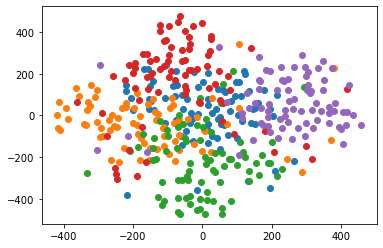

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1])
    plt.show()
    
plot_scatter(np.reshape(np.array(all_features_AE_sigmoid),(-1,100)), all_ids, random_state=2)

### AE

[  8.664442 177.79414  -81.025635]


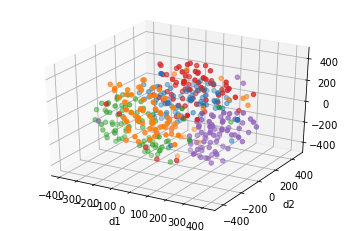

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1], scatter[:,2])
    plt.show()
    
plot_scatter(np.reshape(np.array(all_features_AE),(-1,100)), all_ids, random_state=2)

[  8.664442 177.79414  -81.025635]


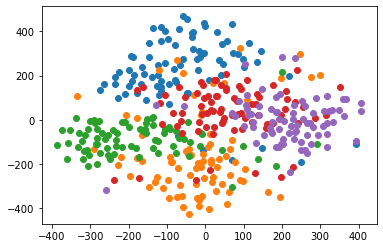

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y, random_state=0,save_fig=None):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3,random_state=random_state,perplexity=30,early_exaggeration=30,n_iter=5000).fit_transform(X)
    print(X_[0])
    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label in labels:
#         indexes = np.where(y==label)[0]
        indexes = []
        for inx in range(X.shape[0]):
            if label==all_ids[inx]:
                indexes.append(inx)
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1])
#     ax.set_xlabel('$d_1$')
#     ax.set_ylabel('$d_2$')
    if save_fig!=None:
        plt.savefig(save_fig,dpi=150)
    plt.show()
        
    
plot_scatter(np.reshape(np.array(all_features_AE),(-1,100)), all_ids, random_state=2, save_fig='AE.pdf')

### PCA

[-295.94547    32.431664  338.94586 ]


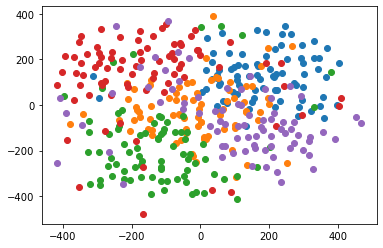

In [15]:
plot_scatter(np.reshape(np.array(all_features_PCA),(-1,100)), all_ids, save_fig='PCA.pdf')

### WLD

In [12]:
all_features[0].shape

(94, 164)

[ -50.44915  243.43456 -328.49646]


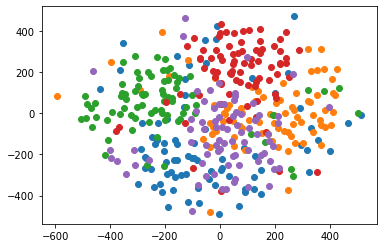

In [16]:
plot_scatter(np.reshape(np.array(all_features),(-1,94*164)), all_ids, save_fig='WLD.pdf')